In [1]:
import os
import torch
import numpy as np
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Custom dataset class with pre-computed text images
class CustomDataset(Dataset):
    def __init__(self, image_dir, text_image_dir, transform=None):
        self.image_dir = image_dir
        self.text_image_dir = text_image_dir
        self.filenames = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.filenames[idx])
        text_img_name = os.path.join(self.text_image_dir, self.filenames[idx])

        image = Image.open(img_name).convert("L")  # Convert to grayscale
        text_image = Image.open(text_img_name).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            text_image = self.transform(text_image)

        return image, text_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

# Define the dataset and dataloader
image_dir = '/local_dir/Train_Images'  # Adjust to your local directory
text_image_dir = '/local_dir/Transcription_Images'  # Adjust to your local directory
dataset = CustomDataset(image_dir=image_dir, text_image_dir=text_image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=8)

2024-07-27 06:16:22.640290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 06:16:22.659145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 06:16:22.682483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 06:16:22.689251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 06:16:22.711247: I tensorflow/core/platform/cpu_feature_guar

In [9]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from diffusers import UNet2DModel, DDPMScheduler
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, img):
        return self.model(img)

class ConditionalDDPMWithGAN(pl.LightningModule):
    def __init__(self):
        super(ConditionalDDPMWithGAN, self).__init__()
        self.model = UNet2DModel(
            sample_size=(64, 2048),
            in_channels=2,  # Update to accept 2 channels (image + condition)
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.criterion = nn.MSELoss()
        self.discriminator = Discriminator(input_shape=(1, 64, 2048))
        self.adversarial_loss = nn.BCEWithLogitsLoss()
        self.automatic_optimization = False  # Use manual optimization

    def forward(self, x, t, condition_image):
        x = torch.cat((x, condition_image), dim=1)
        return self.model(x, t).sample

    def generator_loss(self, predicted_noise, noise, generated_image, condition_image):
        mse_loss = self.criterion(predicted_noise, noise)
        valid = torch.ones_like(self.discriminator(generated_image), requires_grad=False).to(self.device)
        g_loss = self.adversarial_loss(self.discriminator(generated_image), valid)
        return mse_loss + 0.1*g_loss

    def discriminator_loss(self, real_images, fake_images):
        valid = torch.ones_like(self.discriminator(real_images), requires_grad=False).to(self.device)
        fake = torch.zeros_like(self.discriminator(fake_images), requires_grad=False).to(self.device)

        real_loss = self.adversarial_loss(self.discriminator(real_images), valid)
        fake_loss = self.adversarial_loss(self.discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2
        return d_loss

    def training_step(self, batch, batch_idx):
        images, condition_images = batch
        images = images.to(self.device)
        condition_images = condition_images.to(self.device)
        t = torch.randint(0, self.scheduler.config.num_train_timesteps, (images.size(0),), device=self.device).long()
        noise = torch.randn_like(images).to(self.device)
        noisy_images = self.scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)
        predicted_noise = self(noisy_images, t, condition_images)
        generated_image = self.scheduler.step(predicted_noise[0].unsqueeze(0), t[0], noisy_images[0].unsqueeze(0)).prev_sample

        # Manual optimization
        opt_g, opt_d = self.optimizers()

        # Train generator (diffusion model)
        self.toggle_optimizer(opt_g)
        g_loss = self.generator_loss(predicted_noise, noise, generated_image, condition_images)
        self.manual_backward(g_loss)
        opt_g.step()
        opt_g.zero_grad()
        self.untoggle_optimizer(opt_g)

        # Train discriminator
        self.toggle_optimizer(opt_d)
        d_loss = self.discriminator_loss(images, generated_image.detach())
        self.manual_backward(d_loss)
        opt_d.step()
        opt_d.zero_grad()
        self.untoggle_optimizer(opt_d)

        self.log('g_loss', g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('d_loss', d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        lr = 1e-4
        b1, b2 = 0.5, 0.999
        opt_g = torch.optim.Adam(self.model.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

# Initialize the model
model_with_image = ConditionalDDPMWithGAN()

In [10]:
# Define the trainer
trainer = pl.Trainer(
    max_epochs=50,
    precision=16
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
# Train the model
trainer.fit(model_with_image, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params | Mode
--------------------------------------------------------------
0 | model            | UNet2DModel       | 56.6 M | eval
1 | criterion        | MSELoss           | 0      | eval
2 | discriminator    | Discriminator     | 2.8 M  | eval
3 | adversarial_loss | BCEWithLogitsLoss | 0      | eval
--------------------------------------------------------------
0         Trainable params
59.3 M    Non-trainable params
59.3 M    Total params
237.349   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:22, 44.12it/s]

  1%|          | 10/1000 [00:00<00:22, 43.25it/s]

  2%|▏         | 15/1000 [00:00<00:22, 43.03it/s]

  2%|▏         | 20/1000 [00:00<00:22, 42.86it/s]

  2%|▎         | 25/1000 [00:00<00:22, 42.78it/s]

  3%|▎         | 30/1000 [00:00<00:22, 42.75it/s]

  4%|▎         | 35/1000 [00:00<00:22, 42.73it/s]

  4%|▍         | 40/1000 [00:00<00:22, 42.69it/s]

  4%|▍         | 45/1000 [00:01<00:22, 42.62it/s]

  5%|▌         | 50/1000 [00:01<00:22, 42.57it/s]

  6%|▌         | 55/1000 [00:01<00:22, 42.58it/s]

  6%|▌         | 60/1000 [00:01<00:22, 42.61it/s]

  6%|▋         | 65/1000 [00:01<00:21, 42.64it/s]

  7%|▋         | 70/1000 [00:01<00:21, 42.64it/s]

  8%|▊         | 75/1000 [00:01<00:21, 42.67it/s]

  8%|▊         | 80/1000 [00:01<00:21, 42.62it/s]

  8%|▊         | 85/1000 [00:01<00:21, 42.62it/s]

  9%|▉         | 90/1000 [00:02<00:21, 42.57it/s]

 

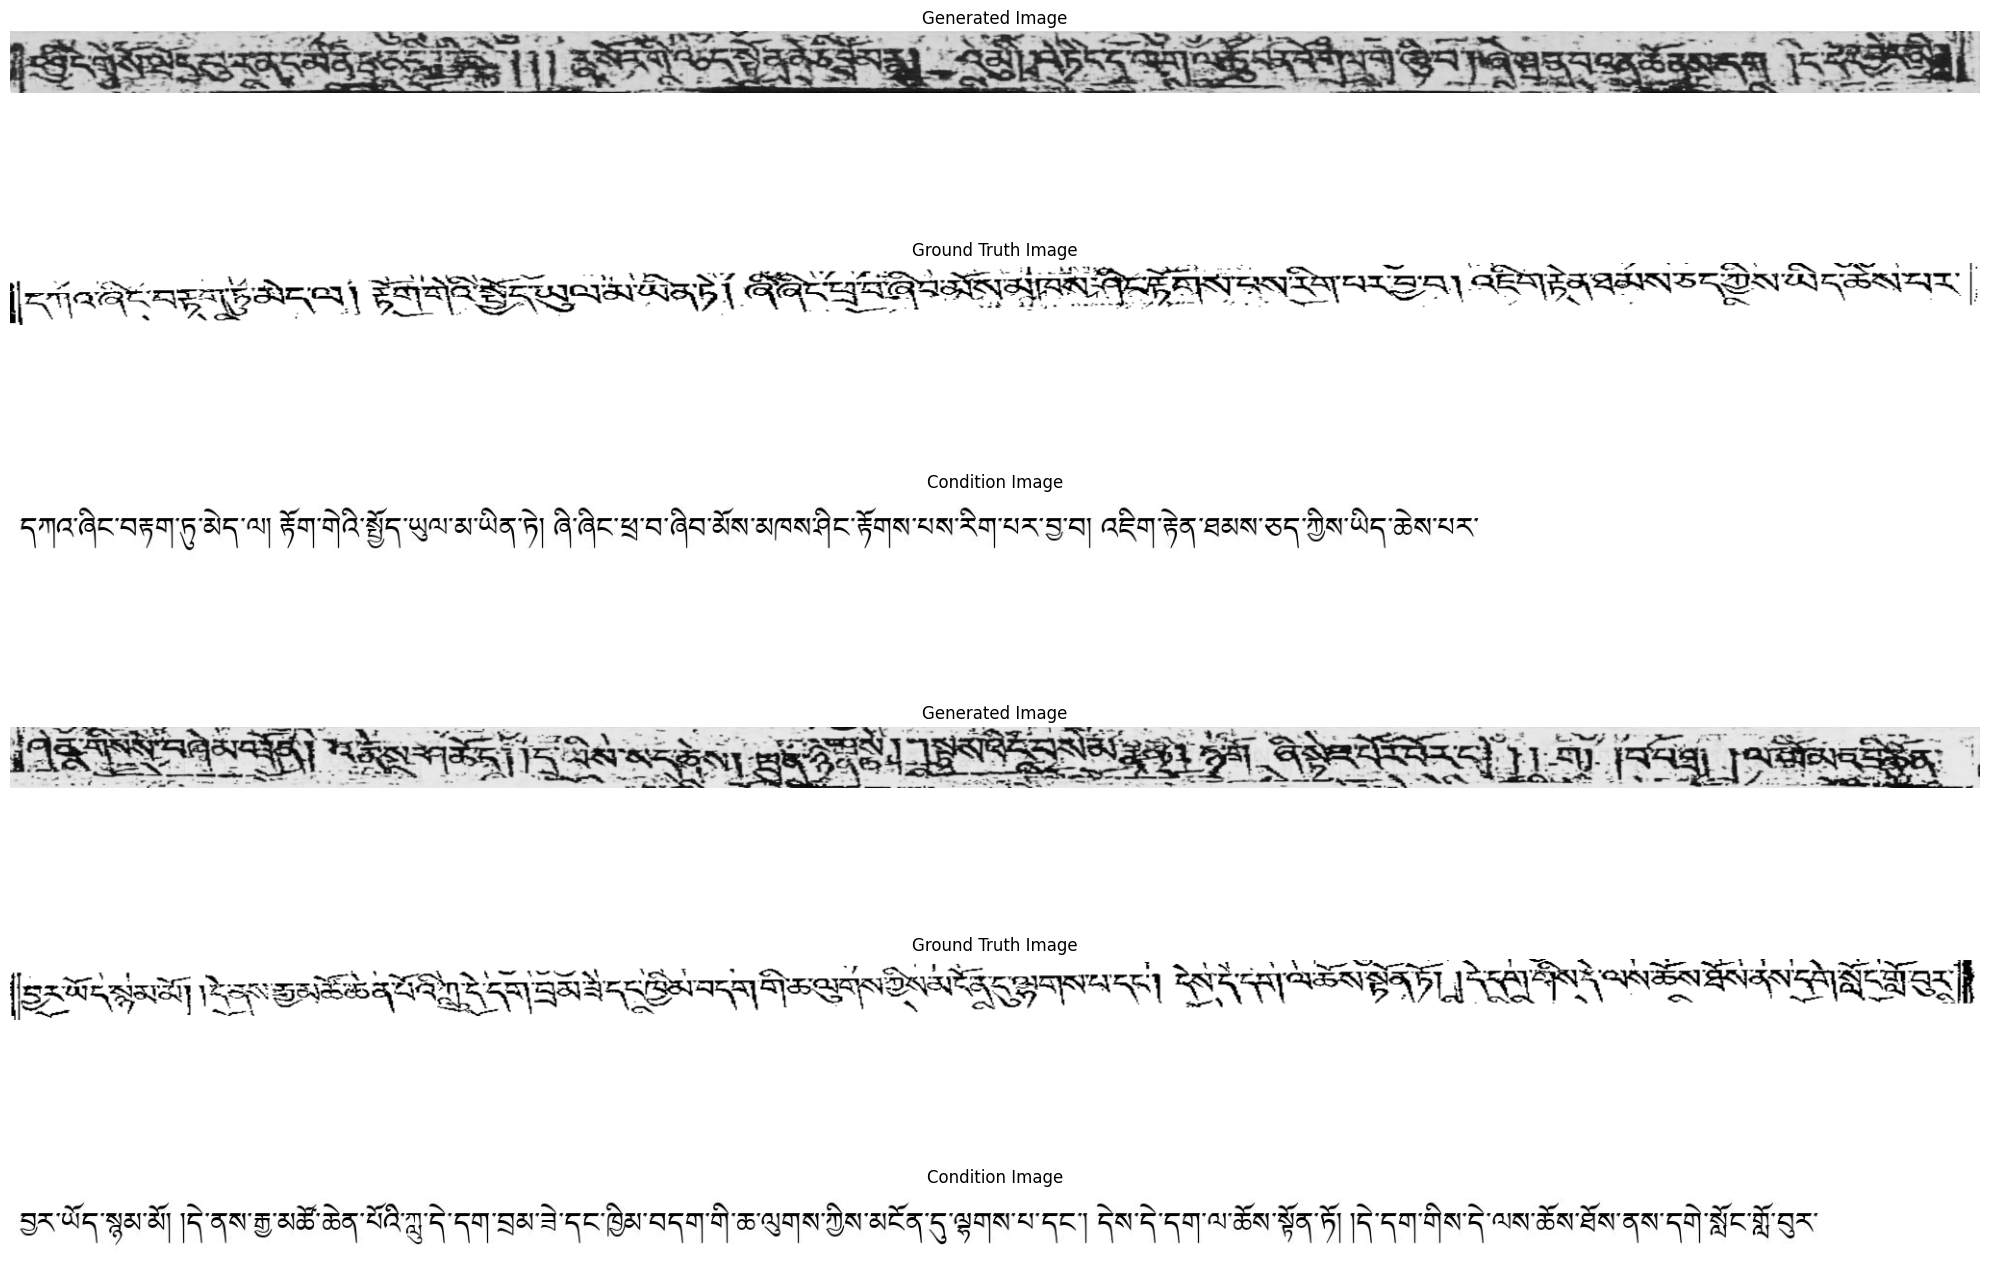

In [12]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Function to generate conditional images from noise using a random text image from training data
def generate_conditional_images(model, scheduler, dataset, num_images=8, device='cuda'):
    model.to(device)  # Ensure model is on the correct device
    model.eval()
    fig, axs = plt.subplots(3 * num_images, 1, figsize=(20, 15))
    with torch.no_grad():
        for i in tqdm(range(num_images)):
            # Select a random image and text image pair from the dataset
            random_idx = random.randint(0, len(dataset) - 1)
            image, random_text_image = dataset[random_idx]
            image = image.to(device).unsqueeze(0)
            random_text_image = random_text_image.to(device).unsqueeze(0)
            noise = torch.randn((1, 1, 64, 2048)).to(device)
            for t in tqdm(range(scheduler.config.num_train_timesteps - 1, -1, -1), leave=False):
                t_tensor = torch.tensor([t], device=device).long()
                predicted_noise = model(noise, t_tensor, random_text_image)
                noise = scheduler.step(model_output=predicted_noise, timestep=t_tensor, sample=noise).prev_sample

            # Display the generated image
            axs[3 * i].imshow(noise.squeeze().cpu().numpy(), cmap='gray')
            axs[3 * i].set_title("Generated Image")
            axs[3 * i].axis('off')

            # Display the ground truth image
            axs[3 * i + 1].imshow(image.squeeze().cpu().numpy(), cmap='gray')
            axs[3 * i + 1].set_title("Ground Truth Image")
            axs[3 * i + 1].axis('off')

            # Display the condition image
            axs[3 * i + 2].imshow(random_text_image.squeeze().cpu().numpy(), cmap='gray')
            axs[3 * i + 2].set_title("Condition Image")
            axs[3 * i + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'dataset' is your data loader or dataset object
generate_conditional_images(model_with_image, model_with_image.scheduler, dataset, num_images=2, device='cuda')
